# Create images of Fourier transform for theory part of report

In [35]:
%pylab inline
#from skimage.io import imread
import matplotlib.gridspec as gridspec

plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'gray'
figsize(4,4)

Populating the interactive namespace from numpy and matplotlib


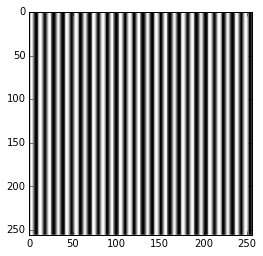

In [36]:
size = 256
img = np.zeros((size,size), dtype=np.uint8)
t = linspace(start=0, stop=50*pi, endpoint=False, num=size)
x,y = meshgrid(t, t)
img[:,:] = 127 + 127*sin(x)
imshow(img);

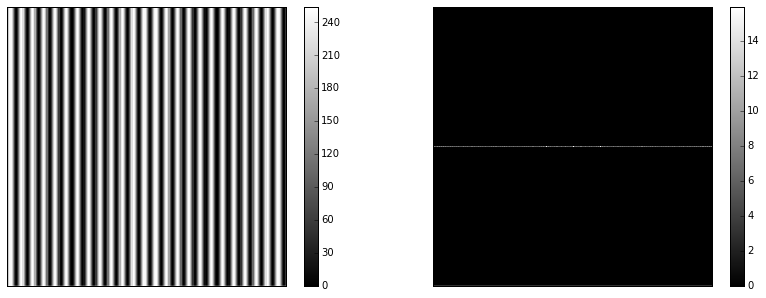

In [63]:
F = fft2(img)
# scale image for viewing - do not take log of zero
F_pow = np.abs(F)
F_pow = log(F_pow.clip(1))

fig, axs = subplots(ncols=2, figsize=(14,5))
plt.setp(axs, xticks=[], yticks=[])
im0 = axs[0].imshow(img)

colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(fftshift(F_pow))
colorbar(im1);

In [4]:
numpy.clip?

Use this image with clear direction of fibers.

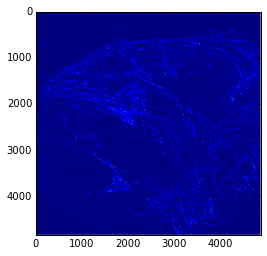

In [31]:
img = imread('unstained/u8v0ch1z0.png')
imshow(img);

The function we want to make better

In [13]:
def angle_ft_line_fit(img, threshold=0.999, debug=False):
    """
    Calculate preferred orientation in image with a line fit in FT.
    
    Parameters
    ----------
    threshold : float
        Percentage of pixels to include in FT for calculating 
        threshold. 0.999 * 512**2 = 262 pixels
        
    Returns
    -------
    float
        Angle
    """
    from skimage.exposure import cumulative_distribution
    from scipy.stats import linregress

    # FT power spectrum
    F = np.abs(fftshift(fft2(img)))
    # do not calculate log(0)
    F[F!=0], F[F==0] = log(F[F!=0]), log(F[F!=0].min())
    # threshold
    cdf = cumulative_distribution(F)
    limit = np.where(cdf[0] > threshold)[0].min()
    threshold_value = cdf[1][limit]
    F = F > threshold_value
    # points
    y,x = np.where(F)
    # cases
    dx = abs(x.max()-x.min())
    dy = abs(y.max()-y.min())
    if dx==0:
        # we have a vertical line
        angle = 90
        b = [0, 1]
    # solve y=mx+c by least-squares regression
    elif dx < dy:
        # linregress is imprecise for dx < dy => swap x,y
        m,c,r,pv,err = linregress(y,x)
        b = (1/m, -c/m)
        # calculate angle (assume line goes through center)
        angle = (90 - arctan(b[0]) / pi * 180) % 180
    else:
        m,c,r,pv,err = linregress(y,x)
        b = (m,c)
        angle = (90 - arctan(b[0]) / pi * 180) % 180

    # show image, FT and fit
    if debug:
        f, ax = subplots(ncols=2, figsize=(8,4))
        ax[0].imshow(img)
        ax[1].imshow(F)
        # add calculated line
        # polynomial generator
        p = np.poly1d(b)
        height, width = img.shape
        if angle != 90:
            line = ([0, width], [p(0), p(width)])
        else:
            line = ([width//2, width//2], [0,height])
        ax[1].plot(*line)
        ax[1].set_title('ang: {:3.0f} r:{:0.2} err:{:0.2}'
                        .format(angle,r,err))
        ax[1].set_xlim(0,width)
        ax[1].set_ylim(height,0)

    return angle
print('angle_ft_line_fit defined')

angle_ft_line_fit defined


# Per block optimation

Pick some blocks in the image, find appropriate thresholds and work out algorithm

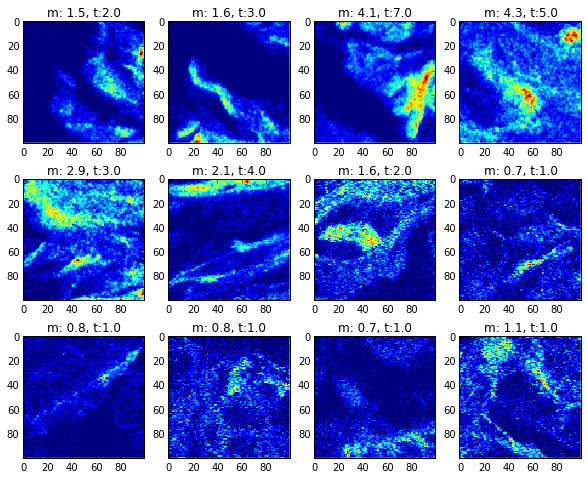

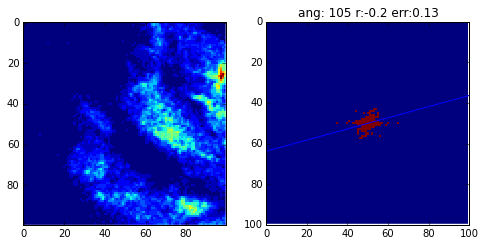

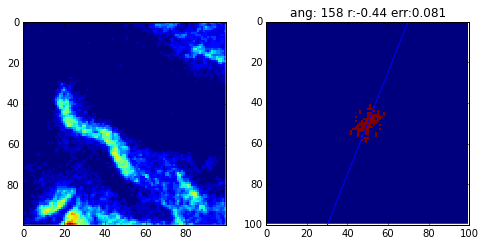

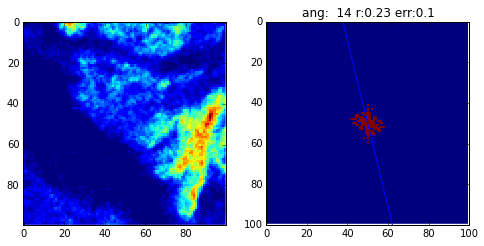

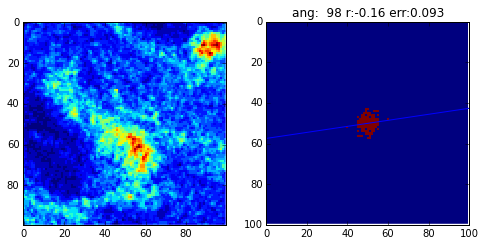

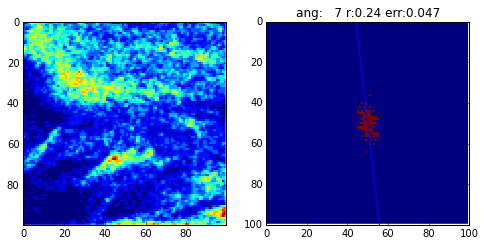

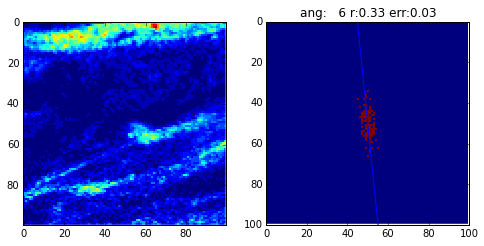

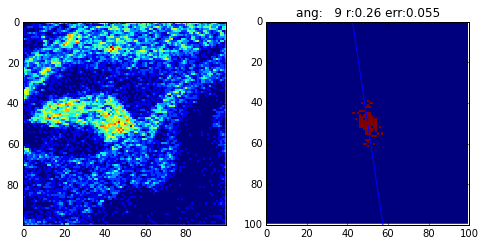

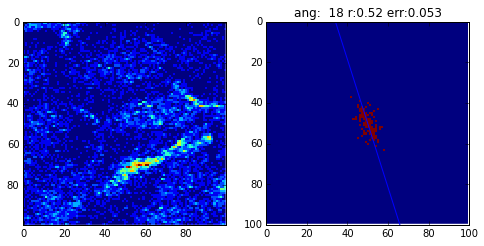

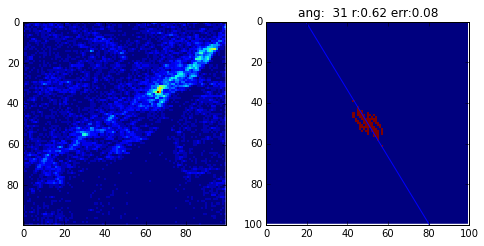

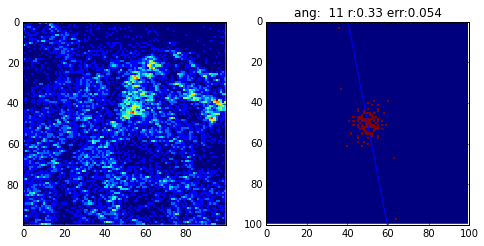

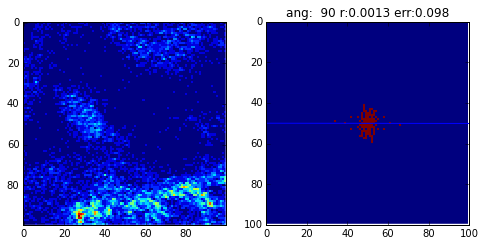

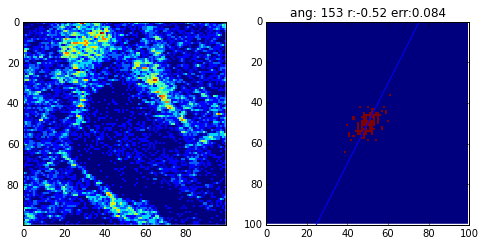

In [105]:
from itertools import product
from skimage.filter import threshold_otsu

bs = 100 # block size
iy,ix = img.shape
by, bx = iy//bs, ix//bs # blocks
bsy, bsx = iy//by, ix//bx # block size
count = 0
f, axs = subplots(nrows=3, ncols=4, figsize=(10,8))
for j,i in product(range(by), range(bx)):
    x,y = j*bs, i*bs
    temp_img = img[y:y+bs, x:x+bs]
    if temp_img.shape[0] < 50 or temp_img.shape[1] < 50:
        continue
    mean = temp_img.mean()
    if mean <= 0:
        continue
    ot = threshold_otsu(temp_img)
    if ot < 1:
        continue
    if count >= 12:
        break
    if (i < 2 # row
        or i > 40
        or j < 2 #column
        or j > 40):
        continue

    ax = axs[count//4, count%4]
    ax.imshow(temp_img)
    ax.set_title('m: {:1.1f}, t:{:1.1f}'.format(mean, ot))
    count += 1
    if count == 6: # pick out image for manual debug
        ii = np.copy(temp_img)
    angle_ft_line_fit(temp_img, threshold=0.99, debug=True)

**Threshold**

otsu threshold > 0 seems to be a good classifier


**Algorithm**

The problem was when dx < dy in points cloud, making the line fitting imprecise.

## Manual debugging

Do it manually, to better control the different steps. This particular image was not getting a good fit (almost vertical line).

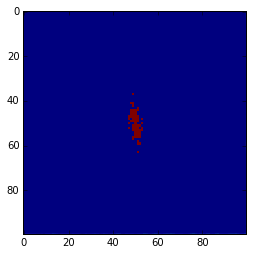

In [89]:
imshow(ii)
F = log(abs(fftshift(fft2(ii))))
imshow(F>7);

Switch the arguments of linregress xx,yy -> yy,xx

In [2]:
Switch the arguments of linregress xx,yy -> yy,xx
from scipy.stats import linregress
yy,xx = np.where(F>6)
m,c,r,pv,err = linregress(yy,xx)
print(m,c,r)
print(pv,err)

SyntaxError: invalid syntax (<ipython-input-2-8b97ab9fb9bd>, line 1)

In [107]:
arctan(m)/pi*180 % 180

10.896844476348919

We are solving $mx+c=y$, but switched x and y:

- $m = \frac{1}{m_1}$
- $c = \frac{-c_1}{m}$

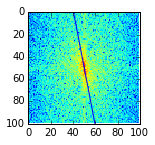

In [114]:
imshow(F)
plot(range(100), np.arange(100)/m-c/m)
xlim(0, 100)
ylim(100,0)
figsize(3,3);

Do the whole image and calc histogram

In [93]:
def angle_histogram(arg):
     # work around for me not knowing how to dview.map multiple arguments
    threshold, filename = arg

    from itertools import product
    from skimage.filter import threshold_otsu
    from skimage.io import imread
    
    img = imread(filename)
    bs = 100 # approx block size
    iy, ix = img.shape
    by, bx = iy//bs, ix//bs   # blocks
    bsy, bsx = iy//by, ix//bx # block size, spread spare pixels

    h = np.zeros(180) # histogram
    for j,i in product(range(by), range(bx)):
        x,y = j*bsx, i*bsy # pos

        temp_img = img[y:y+bsy, x:x+bsx]
        mean = temp_img.mean()

        # small image
        if temp_img.shape[0] < 50 or temp_img.shape[1] < 50:
            continue
        # emtpy image
        if mean == 0:
            continue
        # threshold below noise-threshold
        ot = threshold_otsu(temp_img)
        if (ot < 1):
            continue

        angle = angle_ft_line_fit(temp_img, threshold=threshold)
        angle = int(angle)
        h[angle] += 1

    # make plot (and save it)
    fig, axs = plt.subplots(ncols=2, figsize=(16,8))
    axs[0].imshow(img)
    axs[1].plot(h)
    fn = filename.replace('ed/u', 'ed/angles-ft-line-fit-u')
    fn = fn.replace('.png', str(threshold) + '.png')
    #fig.savefig(fn)

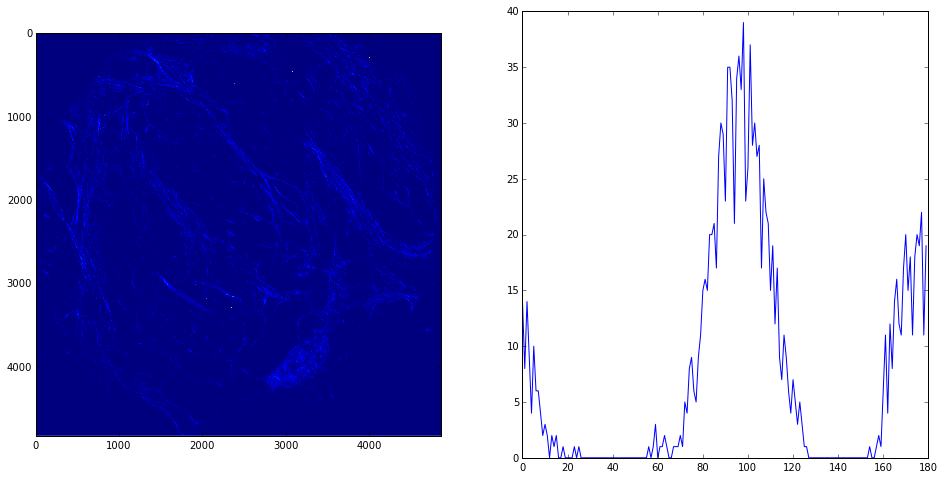

In [95]:
angle_histogram((0.9, '/notebooks/TFY4500/unstained/u1v1ch1z0.png'))

Thats better! :-) No, lets compute histogram for the whole data set in parallel while adjusting threshold: [whole set - ft line fit.ipynb]()